# Dense Neural Network

* Here we are dealing with the most basic neural network. 
The network contains two hidden Dense Neural Networks.

* We use Standard Scaling for input(X) and Mean-Max Scaling for output(Y). Tanh is used as the output activation function. 

* 12th label parameter (one of the Dihedral angles) had some issues which is fixed. 

* IQR method is used to remove outliers.


# Data Augmentation using FFT
I was experimenting with the data by taking its fourier transform to see if it captures the labels better than its original counterpart. 

In [1]:
import numpy as np # linear algebra
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import time
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
X = np.load('/content/drive/My Drive/Quantum Research/QML Scattering/Classical ML Scattering/Input_data_ML.npy')
Y = np.load('/content/drive/My Drive/Quantum Research/QML Scattering/Classical ML Scattering/Output_data_ML.npy')

X=X.astype(np.float64)
Y=Y.astype(np.float64)

print(np.shape(X),np.shape(Y))
#X=np.roll(np.fft.fft(X,axis=1),19,axis=1)
#X=np.real(X)

(1070107, 38) (15, 1070107)


In [17]:
X.dtype, Y.dtype

(dtype('float64'), dtype('float64'))

* I have applied a PCA to the scattering data to remove those components that do not make a difference. (Didn't like the idea)
* I have applied a log on the degrees of freedom to reduce the skewness in the data 
* Float32 to Float64
* I have removed some of the points using the IQR method. (Done)
* I have removed the negative values of the dihedral angles and multiply the bond distances by 10 to get numbers in the same orders as the bonds/dihedrals 
* I have taken 900K data points to train and I have applied
a standard scaler over them. (Done)

In [18]:
pca=PCA(n_components=20)
X=pca.fit_transform(X)

scaler2 =StandardScaler()
X=scaler2.fit_transform(X)

In [19]:
Y=Y.T
Y[:,6:]=Y[:,6:]%(2*np.pi)

y_mean=np.mean(Y[:,:6],axis=0)
y_std=np.std(Y[:,:6],axis=0)
Y[:,:6]=(Y[:,:6]-y_mean)/y_std
print(np.mean(Y[:,:6],axis=0),np.std(Y[:,:6],axis=0))

#Y=np.log(Y)

R=np.array([i for i in range(Y.shape[0])])
np.random.shuffle(R)
X=X[R,:]
Y=Y[R,:]  

Q1=np.quantile(Y,0.10,axis=0)
Q3=np.quantile(Y,0.90,axis=0)
IQR=Q3-Q1
X=X[~((Y < (Q1 - 1.5 * IQR)) |(Y > (Q3 + 1.5 * IQR))).any(axis=1)]
Y=Y[~((Y < (Q1 - 1.5 * IQR)) |(Y > (Q3 + 1.5 * IQR))).any(axis=1)]

y_mean=np.mean(Y[:,:6],axis=0)
y_std=np.std(Y[:,:6],axis=0)
Y[:,:6]=(Y[:,:6]-y_mean)/y_std


X=np.reshape(X,(-1,20,1))

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2)
print(np.shape(xtrain),np.shape(ytrain),np.shape(xtest),np.shape(ytest))

[-2.98008584e-16 -1.73137660e-14  7.44801459e-15 -4.03670206e-15
 -1.53793019e-14 -1.91102771e-14] [1. 1. 1. 1. 1. 1.]
[-2.44956892e-16 -1.20665494e-16 -2.49581086e-17  7.56541718e-17
 -3.65060116e-17  1.65676274e-16] [1. 1. 1. 1. 1. 1.]
(818880, 20, 1) (818880, 15) (204720, 20, 1) (204720, 15)


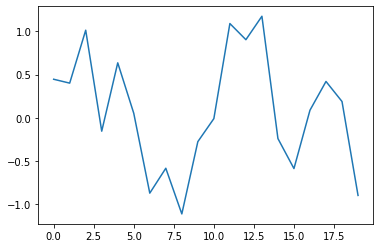

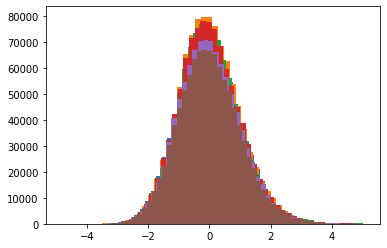

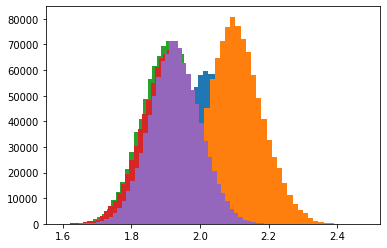

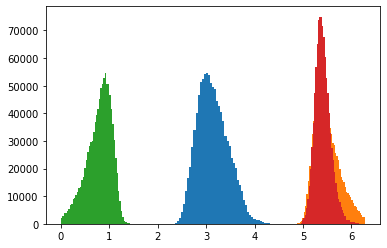

In [20]:
plt.plot(X[10000,:])
plt.show()
for i in range(6):
    plt.hist(Y[:,i],bins=50)
plt.show()
for i in range(6,11):
    plt.hist(Y[:,i],bins=50)
plt.show()
for i in range(11,15):
    plt.hist(Y[:,i],bins=50)
plt.show()

In [ ]:
model = Sequential()

model.add(Flatten(input_shape=(20,1)))
model.add(Dense(475, activation='relu'))
#model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(475, activation='relu'))
#model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(475, activation='relu'))
#model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(15, activation='linear')) #tanh 

In [ ]:
model.compile(loss='mse', optimizer = Adam(lr=1e-4), metrics=["accuracy"])
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 475)               9975      
_________________________________________________________________
batch_normalization_1 (Batch (None, 475)               1900      
_________________________________________________________________
dropout_1 (Dropout)          (None, 475)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 475)               226100    
_________________________________________________________________
batch_normalization_2 (Batch (None, 475)               1900      
_________________________________________________________________
dropout_2 (Dropout)          (None, 475)              

In [ ]:
hist = model.fit(x=xtrain, y=ytrain, batch_size=512,
                epochs=20, 
                verbose=1,  #1 for ETA, 0 for silent
                validation_data=(xtest, ytest), #For speed
                callbacks=[annealer])

Train on 818880 samples, validate on 204720 samples
Epoch 1/20
818880/818880 [==============================] - 95s 116us/step - loss: 0.2517 - accuracy: 0.5018 - val_loss: 0.1372 - val_accuracy: 0.5851
Epoch 2/20
818880/818880 [==============================] - 96s 117us/step - loss: 0.1472 - accuracy: 0.5705 - val_loss: 0.1243 - val_accuracy: 0.6082
Epoch 3/20
818880/818880 [==============================] - 96s 117us/step - loss: 0.1362 - accuracy: 0.5906 - val_loss: 0.1109 - val_accuracy: 0.6338
Epoch 4/20
818880/818880 [==============================] - 97s 119us/step - loss: 0.1251 - accuracy: 0.6081 - val_loss: 0.0965 - val_accuracy: 0.6549
Epoch 5/20
818880/818880 [==============================] - 95s 116us/step - loss: 0.1156 - accuracy: 0.6243 - val_loss: 0.0848 - val_accuracy: 0.6799
Epoch 6/20
818880/818880 [==============================] - 95s 116us/step - loss: 0.1084 - accuracy: 0.6371 - val_loss: 0.0765 - val_accuracy: 0.6969
Epoch 7/20
818880/818880 [================

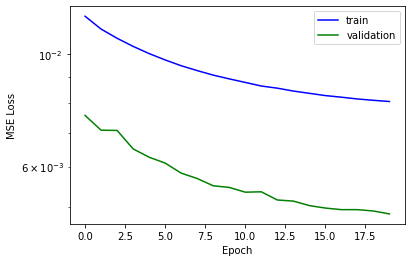

In [ ]:
plt.semilogy(hist.history['loss'], color='b',label='train')
plt.semilogy(hist.history['val_loss'], color='g',label='validation')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [ ]:
Y_hat=model.predict(X)

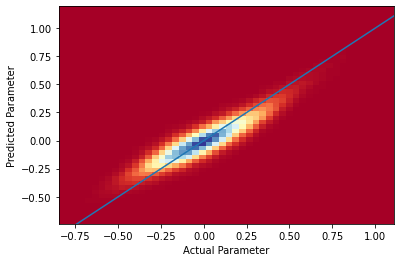

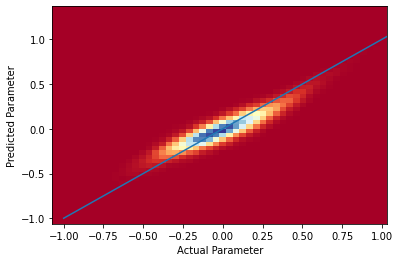

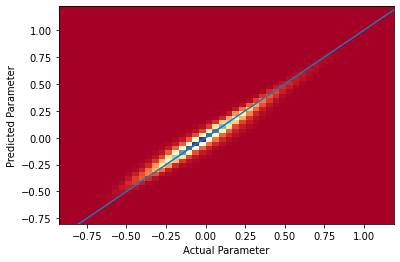

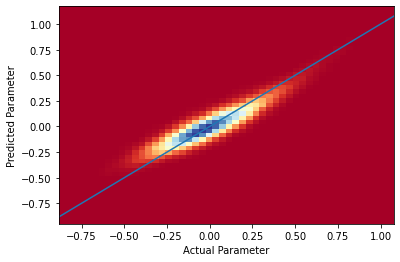

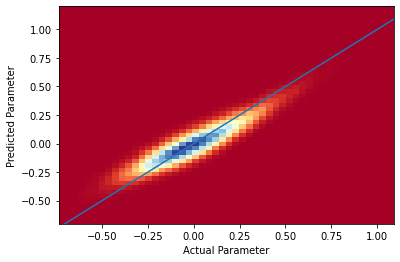

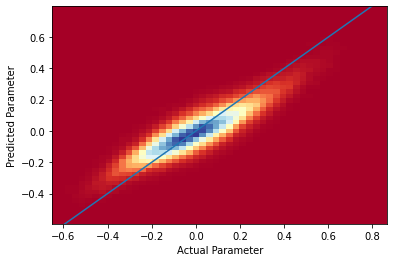

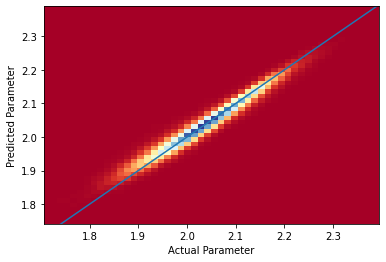

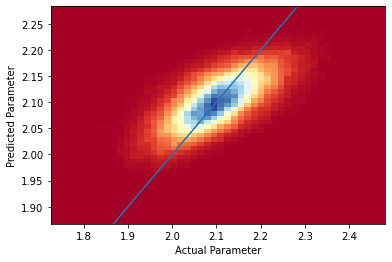

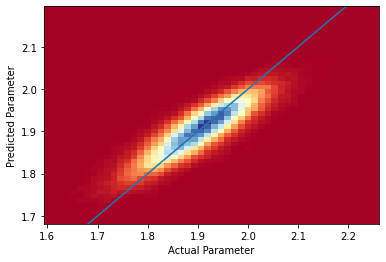

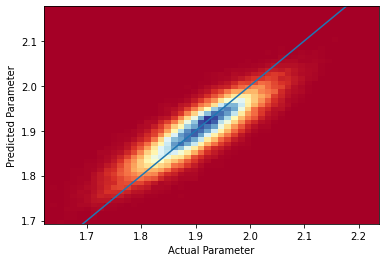

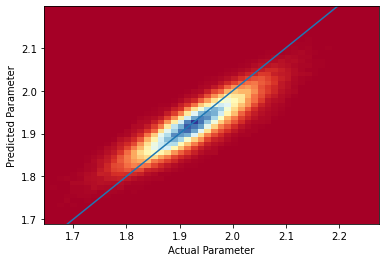

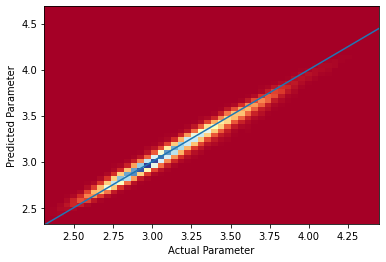

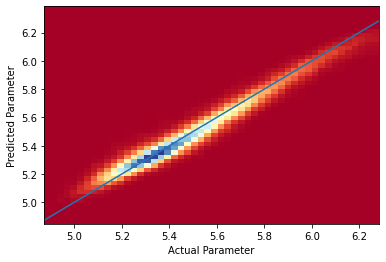

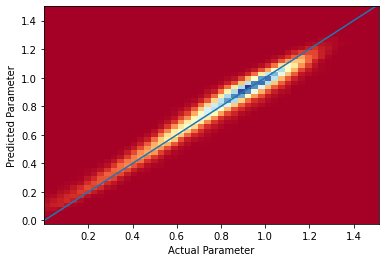

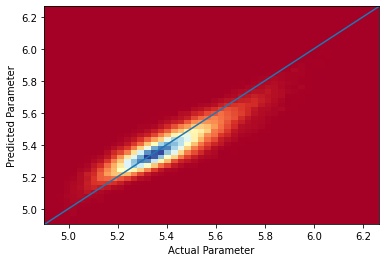

In [ ]:
from matplotlib import cm

for i in range(15):
  plt.hist2d(Y[:,i],Y_hat[:,i],bins=50,cmap=cm.RdYlBu)
  plt.xlabel('Actual Parameter')
  plt.ylabel('Predicted Parameter')
  plt.plot(np.arange(-1,2*np.pi,0.01),np.arange(-1,2*np.pi,0.01))
  plt.show()

[0.808, 0.814, 0.945, 0.822, 0.828, 0.75, 0.946, 0.431, 0.729, 0.74, 0.739, 0.966, 0.944, 0.949, 0.759]


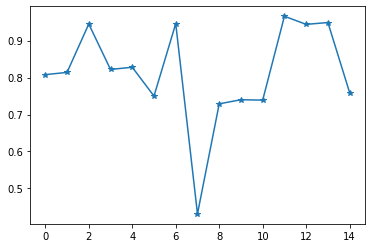

In [ ]:
R2=[]
from sklearn.metrics import r2_score 
for i in range(15):
  R2.append(np.round(r2_score(Y[:,i], Y_hat[:,i]),3))
print(R2)
plt.plot(R2,marker='*')

$R^2$ Error: \\
Cross-Section Data: \\
[0.334	0.368	0.537	0.361	0.361	0.382	0.489	0.154	0.466	0.458	0.491	0.601	0.637	0.649	0.396] \\
Cross-Section Data (Un-normalized): \\
[0.368	0.392	0.577	0.389	0.394	0.392	0.530	0.185	0.488	0.480	0.526	0.638	0.683	0.683	0.433] \\
FFT Data: \\
[0.353	0.372	0.538	0.349	0.377	0.387	0.492	0.158	0.465	0.456	0.499	0.602	0.649	0.658	0.400]	

Andres Model: (50 Epochs) \\
[0.434	0.449	0.643	0.450	0.452	0.457	0.622	0.283	0.541	0.545	0.585	0.711	0.767	0.763	0.530] \\

475 Perceptron Three Layers \\
[0.503, 0.514, 0.676, 0.514, 0.516, 0.507, 0.663, 0.374, 0.597, 0.606, 0.638, 0.746, 0.799, 0.796, 0.607] \\

380 Perceptron Five Layers \\
[0.492, 0.502, 0.674, 0.505, 0.504, 0.503, 0.666, 0.366, 0.589, 0.596, 0.631, 0.746, 0.806, 0.797, 0.6]

In [ ]:
Y_mean=np.mean(Y,axis=0)
np.round(1-np.sum((Y-Y_hat)**2,axis=0)/np.sum((Y-Y_mean)**2,axis=0),3)

array([0.37 , 0.386, 0.569, 0.352, 0.352, 0.404, 0.531, 0.183, 0.472,
       0.469, 0.525, 0.64 , 0.677, 0.682, 0.427], dtype=float32)